In [1]:
import pybma

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

In [2]:
m = pybma.load_model("../models/ToyModelUnstable.json")
qn = pybma.model_to_qn(m)
p = pybma.check_stability(qn)

print("###Unstable model###")
print(p)

#knock out a variable
m['Model']['Variables'][0]['Formula'] = "0"
qn = pybma.model_to_qn(m)
pko = pybma.check_stability(qn)

print("###Modified Model###")
print(pko)

###Unstable model###
{'ProofProgression': {'stable': False, 'history': [(3, {1: (0, 4), 2: (0, 4), 3: (0, 4)}), (2, {1: (0, 4), 2: (0, 4), 3: (0, 4)}), (1, {1: (0, 4), 2: (0, 4), 3: (0, 4)}), (0, {1: (0, 4), 2: (0, 4), 3: (0, 4)})]}, 'CounterExample': {'Result': 'CExCycle', 'Example': {'1^0': 2, '1^1': 1, '1^2': 2, '1^3': 2, '1^4': 3, '1^5': 2, '1^6': 2, '2^0': 2, '2^1': 2, '2^2': 1, '2^3': 2, '2^4': 2, '2^5': 3, '2^6': 2, '3^0': 3, '3^1': 2, '3^2': 2, '3^3': 1, '3^4': 2, '3^5': 2, '3^6': 3}}}
###Modified Model###
{'ProofProgression': {'stable': True, 'history': [(4, {1: (0, 0), 2: (0, 0), 3: (0, 0)}), (3, {1: (0, 0), 2: (0, 0), 3: (0, 0)}), (2, {1: (0, 0), 2: (0, 0), 3: (0, 0)}), (1, {1: (0, 0), 2: (0, 0), 3: (0, 4)}), (0, {1: (0, 0), 2: (0, 4), 3: (0, 4)})]}, 'CounterExample': None}


In [3]:
#functions to process proof progressions to turn them into a heatmap

def singleton(a):
    if a[0]==a[1]:
        return 1
    else:
        return 0
    
def timeHM(timepoint):
    state = []
    for var in timepoint.keys():
        state.append(singleton(timepoint[var]))
    return state

def timeText(timepoint):
    state = []
    for var in timepoint.keys():
        state.append(str(timepoint[var][0])+"-"+str(timepoint[var][1]))
    return state

In [4]:
def proofProgressionPlot(p,annotate=False):
    # Set font at the start
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
    
    progression = p["ProofProgression"]["history"]
    data = np.fliplr(np.array([ timeHM(time[1]) for time in progression ]).transpose())
    # Create custom colormap with your two colors
    colors = ['#E8D4E8', '#C8E8E0']  # purple-pink and mint-green
    cmap = mcolors.ListedColormap(colors)
    
    # Create figure and plot
    fig, ax = plt.subplots(figsize=(12, 4))
    
    # Use pcolormesh instead of imshow - it handles grid lines better
    im = ax.pcolormesh(data, cmap=cmap, vmin=0, vmax=1, edgecolors='white', linewidth=2)
    
    # Add text to each cell
    if annotate:
        text_data = np.fliplr(np.array([ timeText(time[1]) for time in progression ]).transpose())
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                text = ax.text(j + 0.5, i + 0.5, str(text_data[i, j]),
                              ha="center", va="center", color="black", fontsize=10)
    
    # Invert y-axis to match imshow behavior (top to bottom)
    ax.invert_yaxis()
    
    # Remove all ticks and labels
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    
    # Remove spines (borders)
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    plt.tight_layout()
    plt.show()
    

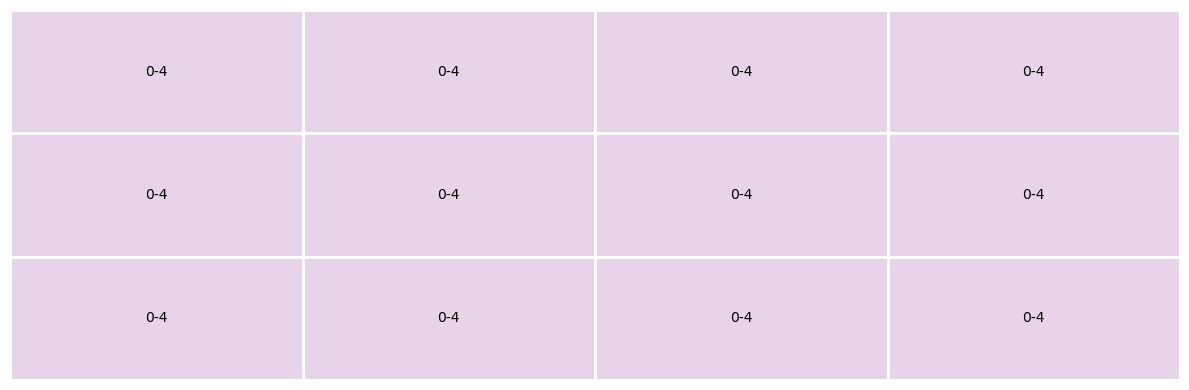

In [5]:
proofProgressionPlot(p,True)

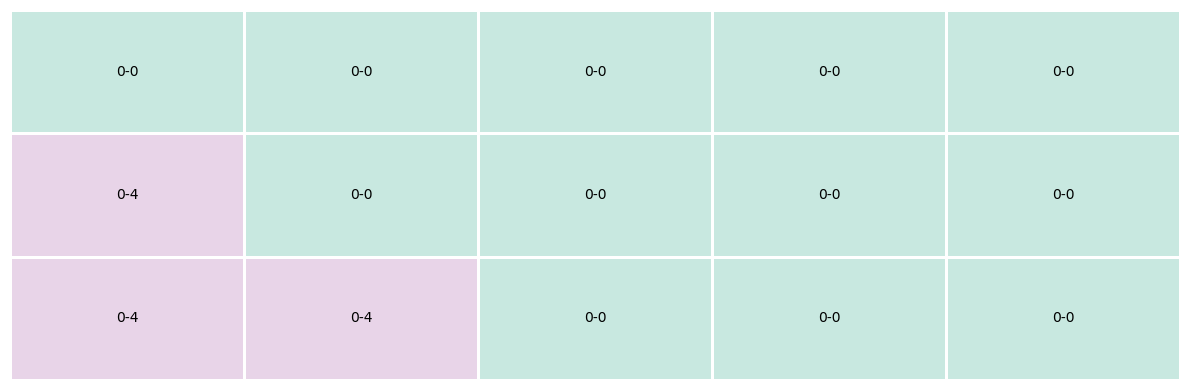

In [6]:
proofProgressionPlot(pko,True)

In [7]:
def simulation_graph(data_dict, title="Simulation Graph", nameMap=None):
    """
    Create a line graph matching the style shown.
    
    Parameters:
    data_dict: Dictionary with keys as labels and values as lists of y-values
               Example: {'a': [0,0,3,3,2,1,1,1,3,3,3], 'b': [0,0,0,3,3,2,1,1,1,3,3], ...}
    title: Graph title
    """
    # Set font properties
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
    plt.rcParams['font.size'] = 11
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot each line
    for label, y_values in data_dict.items():
        x_values = range(len(y_values))
        if nameMap != None:
            label = nameMap[label]
        ax.plot(x_values, y_values, #color=colors.get(label, 'black'), 
                linewidth=2.5, label=label)
    
    # Styling
    ax.set_title(title, fontsize=13, loc='left', pad=15, fontweight='normal')
    ax.grid(True, alpha=0.3, linewidth=0.8)
    ax.set_axisbelow(True)
    
    # Set y-axis to show integer values
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    # Add legend with font styling
    ax.legend(loc='best', frameon=False, fontsize=11)
    
    # Style tick labels
    ax.tick_params(labelsize=10)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

In [8]:
cexTrace = pybma.bmaTrace_to_dict(p['CounterExample']['Example'])

In [9]:
nameMap = pybma.model_to_variableIDdict(m)

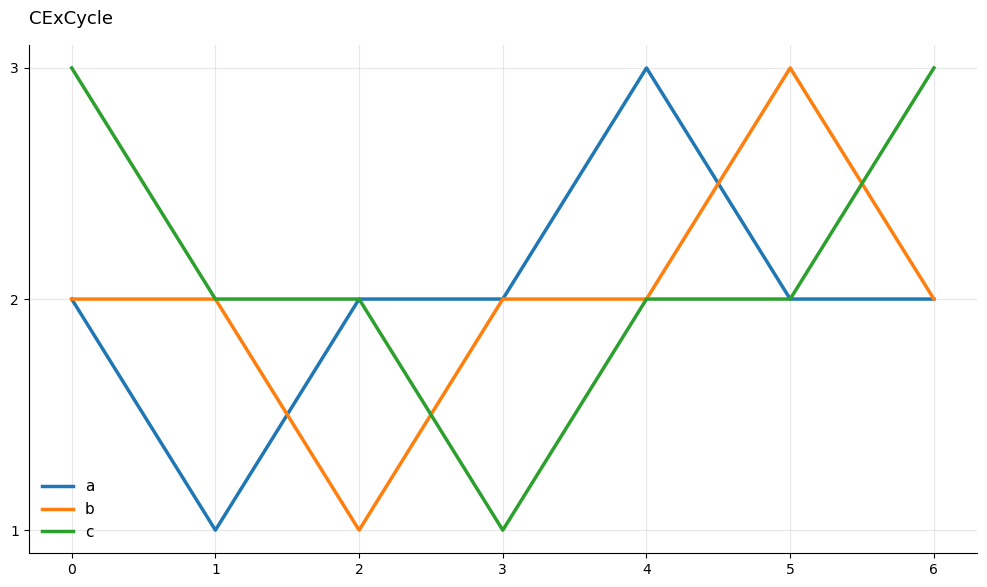

In [10]:
simulation_graph(cexTrace,p['CounterExample']['Result'],nameMap)

In [11]:
m['Model']['Variables']

[{'Name': 'a', 'Id': 1, 'RangeFrom': 0, 'RangeTo': 4, 'Formula': '0'},
 {'Name': 'b', 'Id': 2, 'RangeFrom': 0, 'RangeTo': 4, 'Formula': ''},
 {'Name': 'c', 'Id': 3, 'RangeFrom': 0, 'RangeTo': 4, 'Formula': ''}]